In [398]:
import os
import sys
import plotly.express as px
import torch as t
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
import numpy as np
import einops
from jaxtyping import Int, Float
from typing import List, Optional, Tuple
import functools
from tqdm import tqdm
from IPython.display import display
import webbrowser
import gdown
from transformer_lens.hook_points import HookPoint
from transformer_lens import utils, HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
import circuitsvis as cv
import json

In [399]:
def top_predictions(logits, n_tokens=10):
    # Ensure logits is a numpy array for easy manipulation
    logits = logits.detach().numpy()
    
    # Get the last set of logits if logits represents a sequence of predictions
    next_token_logits = logits[0, -1] if logits.ndim > 1 else logits
    
    # Find the indices of the top n_tokens logits
    top_tokens = np.argsort(next_token_logits)[-n_tokens:][::-1]
    
    # Extract the probabilities (or logits) of these top tokens
    top_tokens_probs = next_token_logits[top_tokens]
    
    return top_tokens.tolist(), top_tokens_probs.tolist()

In [400]:
model = HookedTransformer.from_pretrained("gpt2")

Loaded pretrained model gpt2 into HookedTransformer


In [412]:
# Load all prompts for ICL
prompts = json.load(open('LSE-AI/prompts.json'))

In [426]:
results = {}
x = 1
y = 1
icl_lenght = 11
n = 50

for i in range(n + 1):
    if i % 2 == 0:
        x += 1
    else:
        y += 1
    results[i] = [x,y]

In [430]:
i = 0
for key in prompts:
    
    logits, loss = model(prompts[key], return_type="both")
    top_tokens, top_probs = top_predictions(logits)
    top_prediction = model.tokenizer.batch_decode(top_tokens)[0]
    
    results[i].extend([int(key), int(top_prediction), int(key) - int(top_prediction)])

    print(results[i])

    i += 1

[2, 1, 23, 23, 23, 23, 0]
[2, 2, 24, 24, 0]
[3, 2, 35, 34, 1]
[3, 3, 36, 36, 0]
[4, 3, 47, 46, 1]
[4, 4, 48, 48, 0]
[5, 4, 59, 56, 3]
[5, 5, 60, 60, 0]
[6, 5, 71, 69, 2]
[6, 6, 72, 70, 2]
[7, 6, 83, 79, 4]
[7, 7, 84, 80, 4]
[8, 7, 95, 99, -4]
[8, 8, 96, 100, -4]
[9, 8, 107, 100, 7]
[9, 9, 108, 101, 7]
[10, 9, 119, 112, 7]
[10, 10, 120, 120, 0]
[11, 10, 131, 124, 7]
[11, 11, 132, 124, 8]
[12, 11, 143, 138, 5]
[12, 12, 144, 140, 4]
[13, 12, 155, 164, -9]
[13, 13, 156, 165, -9]
[14, 13, 167, 175, -8]
[14, 14, 168, 168, 0]
[15, 14, 179, 176, 3]
[15, 15, 180, 175, 5]
[16, 15, 191, 195, -4]
[16, 16, 192, 180, 12]
[17, 16, 203, 191, 12]
[17, 17, 204, 195, 9]
[18, 17, 215, 199, 16]
[18, 18, 216, 210, 6]
[19, 18, 227, 216, 11]
[19, 19, 228, 216, 12]
[20, 19, 239, 229, 10]
[20, 20, 240, 230, 10]
[21, 20, 251, 236, 15]
[21, 21, 252, 234, 18]
[22, 21, 263, 249, 14]
[22, 22, 264, 246, 18]
[23, 22, 275, 265, 10]
[23, 23, 276, 265, 11]
[24, 23, 287, 273, 14]
[24, 24, 288, 276, 12]
[25, 24, 299, 277, 

In [434]:
results[0] = [2, 1, 23, 23, 0]

In [435]:
results

{0: [2, 1, 23, 23, 0],
 1: [2, 2, 24, 24, 0],
 2: [3, 2, 35, 34, 1],
 3: [3, 3, 36, 36, 0],
 4: [4, 3, 47, 46, 1],
 5: [4, 4, 48, 48, 0],
 6: [5, 4, 59, 56, 3],
 7: [5, 5, 60, 60, 0],
 8: [6, 5, 71, 69, 2],
 9: [6, 6, 72, 70, 2],
 10: [7, 6, 83, 79, 4],
 11: [7, 7, 84, 80, 4],
 12: [8, 7, 95, 99, -4],
 13: [8, 8, 96, 100, -4],
 14: [9, 8, 107, 100, 7],
 15: [9, 9, 108, 101, 7],
 16: [10, 9, 119, 112, 7],
 17: [10, 10, 120, 120, 0],
 18: [11, 10, 131, 124, 7],
 19: [11, 11, 132, 124, 8],
 20: [12, 11, 143, 138, 5],
 21: [12, 12, 144, 140, 4],
 22: [13, 12, 155, 164, -9],
 23: [13, 13, 156, 165, -9],
 24: [14, 13, 167, 175, -8],
 25: [14, 14, 168, 168, 0],
 26: [15, 14, 179, 176, 3],
 27: [15, 15, 180, 175, 5],
 28: [16, 15, 191, 195, -4],
 29: [16, 16, 192, 180, 12],
 30: [17, 16, 203, 191, 12],
 31: [17, 17, 204, 195, 9],
 32: [18, 17, 215, 199, 16],
 33: [18, 18, 216, 210, 6],
 34: [19, 18, 227, 216, 11],
 35: [19, 19, 228, 216, 12],
 36: [20, 19, 239, 229, 10],
 37: [20, 20, 240, 230

In [436]:
with open("LSE-AI/predictions.json", "w") as file:
    json.dump(results, file, indent=2)

In [382]:
 # Load an ICL sequence
sequence = """Input: 2, Output: 5
Input: 3, Output: 7
Input: 4, Output: 9
Input: 5, Output: 11
Input: 6, Output: 13
Input: 7, Output: 15
Input: 8, Output: 17
Input: 9, Output: 19
Input: 10, Output: 21
Input: 11, Output:"""


# Run the model and get logits and activations
logits, loss = model(sequence, return_type="both")
print("Model loss:", loss)

Model loss: tensor(0.9522, grad_fn=<NegBackward0>)


In [383]:
top_tokens, top_probs = top_predictions(logits)
top_words = model.tokenizer.batch_decode(top_tokens)


'logit diff: ' + str(top_probs[0] - top_probs[1]), top_words, top_probs

('logit diff: 0.7993278503417969',
 [' 23', ' 22', ' 24', ' 25', ' 26', ' 27', ' 28', ' 21', ' 29', ' 20'],
 [24.758773803710938,
  23.95944595336914,
  23.71446418762207,
  23.343725204467773,
  22.01938819885254,
  21.71127700805664,
  21.47074317932129,
  21.109939575195312,
  20.709959030151367,
  19.77352523803711])

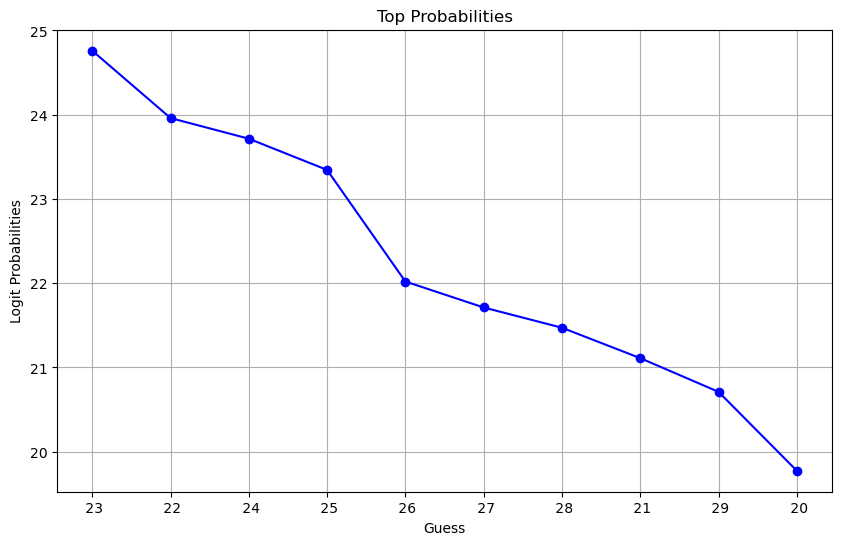

In [384]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(top_words, top_probs, marker='o', linestyle='-', color='b')
plt.title('Top Probabilities')
plt.xlabel('Guess')
plt.ylabel('Logit Probabilities')
plt.grid(True)
plt.show()